# 월간 데이콘 항공편 지연 예측 AI 경진대회
https://dacon.io/competitions/official/236094/overview/description

## 23-1학기 빅데이터처리 기말 프로젝트
### 팀원
- 이시내
- 유동혁
- 김명학
- 박준수
--- 
### 이 후 수정 방법:
1. ['Delay_per']의 평균을 내서 상위 50퍼는 Delayed로 간주, ['Delay_num']에 삽입
    - 0.6821020302점 달성.
2. labeled['Delay_num']의 평균을 내서 (약 0.17647), 상위 20%의 ['Delay_per']를 Delayed로 간주
    - 0.7751130567점 달성
3. 전처리 이후 train['Delay_per'](dtype = float)만 이용해서 no tune xgboost 실행
    - 0.7464493418점 달성
4. 전처리 과정 중 unlabeled의 전체를 한번에 채워넣는 것이 아니라, unlabeled를 여러 조각으로 나눠 조금씩 labeled에 합침
    - 0.6857301445점 달성
5. 나눠서 학습하는 과정에서 labeled['Delay_per']를 기준으로 학습하고 전체 평균을 기준으로 train['Delay_num']을 채워넣음
    - 0.6561362148점 달성
6. EDT, EAT 데이터 전처리 후 학습
    - 이는 `항공운항지연예측 Final-model` 파일에 저장함
    - public: 0.6337836841점 , private: 0.7080757848점
7. 대회 종료 후, [private점수 1위의 코드](https://dacon.io/competitions/official/236094/codeshare/8341)를 참고하여 수정한 모델
    - 이는 `항공운항지연예측 with 1st.ipynb` 파일에 저장함
    - public: 0.6234701617점, praivate: 0.7169214489점


In [1]:
# 경고메세지 끄기
import warnings
warnings.filterwarnings(action='ignore')

# 프로그램 시간 측정
import math
import time
import datetime
time_start =  time.time()
print('시작 시각:', time.strftime('%Y.%m.%d - %H:%M:%S'))

시작 시각: 2023.05.16 - 00:31:32


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import random
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 데이터 불러오기

In [4]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

csv_to_parquet('./train.csv', 'train')
csv_to_parquet('./test.csv', 'test')

train Done.
test Done.


In [5]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              893495 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         893477 non-null   object 
 13  Distance                  10

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, TEST_000000 to TEST_999999
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Not_Delayed  1000000 non-null  int64
 1   Delayed      1000000 non-null  int64
dtypes: int64(2)
memory usage: 22.9+ MB


## 데이터 전처리 과정

#### 1. Delay열을 제외한 열에 존재하는 결측값을 채웁니다.

##### 1-1. EDT, EAT의 전처리를 진행합니다. 

In [9]:
#EDT, EAT가 모두 결측값인 행 제거
train = train.dropna(subset=['Estimated_Departure_Time', 'Estimated_Arrival_Time'], how='all')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988312 entries, 1 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        988312 non-null  object 
 1   Month                     988312 non-null  int64  
 2   Day_of_Month              988312 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null  float64
 4   Estimated_Arrival_Time    890960 non-null  float64
 5   Cancelled                 988312 non-null  int64  
 6   Diverted                  988312 non-null  int64  
 7   Origin_Airport            988312 non-null  object 
 8   Origin_Airport_ID         988312 non-null  int64  
 9   Origin_State              880539 non-null  object 
 10  Destination_Airport       988312 non-null  object 
 11  Destination_Airport_ID    988312 non-null  int64  
 12  Destination_State         880518 non-null  object 
 13  Distance                  988312 non-null  float6

In [11]:
# Estimated Departure Time, Estimated Arrival Time을 분으로 환산
# EDT, EAT는 hhmm의 형태인 4자리 정수이기 때문에, 아래 함수를 통해 분 형태로 바꿉니다.
def convert_time(time):
    if pd.isna(time):
        return None
    else:
        hours = time // 100
        minutes = time % 100
        return hours * 60 + minutes

train['Estimated_Departure_Time'] = train['Estimated_Departure_Time'].apply(convert_time)
train['Estimated_Arrival_Time'] = train['Estimated_Arrival_Time'].apply(convert_time)
test['Estimated_Departure_Time'] = test['Estimated_Departure_Time'].apply(convert_time)
test['Estimated_Arrival_Time'] = test['Estimated_Arrival_Time'].apply(convert_time)

In [12]:
#test 데이터셋에서 결측값을 채우기 위해 EDT, EAT가 모두 결측값인 행이 제거된 test_filtered 사용
test_filtered = test.dropna(subset=['Estimated_Departure_Time', 'Estimated_Arrival_Time'])

#EDT, EAT가 모두 결측값인 행의 결측값 채우기 위해 test_filtered를 사용
# Origin_Airport와 Destination_Airport로 그룹화합니다.
grouped_df = test_filtered.groupby(['Origin_Airport', 'Destination_Airport'])

# 각 그룹의 Estimated_Arrival_Time과 Estimated_Departure_Time 각각의 평균을 계산
mean_departure = grouped_df['Estimated_Departure_Time'].mean()
mean_arrival = grouped_df['Estimated_Arrival_Time'].mean()

mean_departure_dict = mean_departure.reset_index().set_index(['Origin_Airport', 'Destination_Airport'])['Estimated_Departure_Time'].to_dict()
mean_arrival_dict = mean_arrival.reset_index().set_index(['Origin_Airport', 'Destination_Airport'])['Estimated_Arrival_Time'].to_dict()

print("Mean Departure Dictionary:")
print(mean_departure_dict)
print("\nMean Arrival Dictionary:")
print(mean_arrival_dict)

Mean Departure Dictionary:
{('ABE', 'ATL'): 743.7875, ('ABE', 'CLT'): 759.4269662921348, ('ABE', 'DTW'): 752.8536585365854, ('ABE', 'FLL'): 928.5555555555555, ('ABE', 'MYR'): 758.9285714285714, ('ABE', 'ORD'): 736.3941605839416, ('ABE', 'PGD'): 910.0526315789474, ('ABE', 'PHL'): 723.140625, ('ABE', 'PIE'): 848.1176470588235, ('ABE', 'SAV'): 969.0, ('ABE', 'SFB'): 848.5074626865671, ('ABE', 'SRQ'): 749.0, ('ABI', 'DFW'): 674.4814814814815, ('ABQ', 'ATL'): 641.5178571428571, ('ABQ', 'AUS'): 835.4901960784314, ('ABQ', 'BWI'): 658.359375, ('ABQ', 'DAL'): 776.9672897196261, ('ABQ', 'DEN'): 754.866220735786, ('ABQ', 'DFW'): 728.0195121951219, ('ABQ', 'HOU'): 704.9074074074074, ('ABQ', 'IAH'): 772.4829545454545, ('ABQ', 'JFK'): 1358.6052631578948, ('ABQ', 'LAS'): 832.022346368715, ('ABQ', 'LAX'): 785.0074074074074, ('ABQ', 'MCI'): 666.0526315789474, ('ABQ', 'MCO'): 460.8333333333333, ('ABQ', 'MDW'): 795.1162790697674, ('ABQ', 'MSP'): 835.2666666666667, ('ABQ', 'OAK'): 845.0104166666666, ('ABQ

In [13]:
def fill_arrival_time_test(row):
    if pd.isna(row['Estimated_Arrival_Time']) and pd.isna(row['Estimated_Departure_Time']):
        key = (row['Origin_Airport'], row['Destination_Airport'])
        if key in mean_arrival_dict:
            return mean_arrival_dict[key]
        else:
            return None
    else:
        return row['Estimated_Arrival_Time']

# 결측치가 있는 행에서 계산된 값을 사용하여 Estimated_Arrival_Time을 채웁니다.
test['Estimated_Arrival_Time'] = test.apply(fill_arrival_time_test, axis=1)

In [14]:
#train 데이터에서 같은 Origin_Airport와 Destination_Airport 사이의 소요 시간의 평균 계산
mean_diff = train.groupby(['Origin_Airport', 'Destination_Airport']).apply(
    lambda group: (group['Estimated_Arrival_Time'] - group['Estimated_Departure_Time']).mean()
).to_dict()

print(mean_diff)

{('ABE', 'ATL'): 133.0810810810811, ('ABE', 'BNA'): 58.666666666666664, ('ABE', 'CLT'): 130.21686746987953, ('ABE', 'DTW'): 112.06896551724138, ('ABE', 'FLL'): 166.875, ('ABE', 'MYR'): 91.57142857142857, ('ABE', 'ORD'): 81.02521008403362, ('ABE', 'PGD'): 161.88235294117646, ('ABE', 'PHL'): 44.901408450704224, ('ABE', 'PIE'): 156.66666666666666, ('ABE', 'SAV'): 117.0, ('ABE', 'SFB'): 146.93939393939394, ('ABI', 'DFW'): 60.89772727272727, ('ABQ', 'ATL'): 299.0921052631579, ('ABQ', 'AUS'): 106.5576923076923, ('ABQ', 'BWI'): 341.6949152542373, ('ABQ', 'DAL'): 160.6217616580311, ('ABQ', 'DEN'): 81.72072072072072, ('ABQ', 'DFW'): 167.9034090909091, ('ABQ', 'HOU'): 181.03174603174602, ('ABQ', 'IAH'): 188.6242774566474, ('ABQ', 'JFK'): -1074.2727272727273, ('ABQ', 'LAS'): 33.86857142857143, ('ABQ', 'LAX'): 66.64419475655431, ('ABQ', 'MCI'): 170.78947368421052, ('ABQ', 'MCO'): 217.0, ('ABQ', 'MDW'): 219.87012987012986, ('ABQ', 'MSP'): 212.23076923076923, ('ABQ', 'OAK'): 73.90625, ('ABQ', 'ORD')

In [15]:
#Origin_Airport와 Destination_Airport가 같고 Estimated_Departure_Time만 확인가능할 경우 공항사이 결리는 시간 평균 더하기
def fill_arrival_time(row):
    if pd.isna(row['Estimated_Arrival_Time']):
        key = (row['Origin_Airport'], row['Destination_Airport'])
        if key in mean_diff:
            return (row['Estimated_Departure_Time'] + mean_diff[key])%1440 #시차계산
        else:
            return None
    else:
        return row['Estimated_Arrival_Time']

# 결측치가 있는 행에서 계산된 값을 사용하여 Estimated_Arrival_Time을 채웁니다.
train['Estimated_Arrival_Time'] = train.apply(fill_arrival_time, axis=1)
test['Estimated_Arrival_Time'] = test.apply(fill_arrival_time, axis=1)

print(train)
print(test)

                  ID  Month  Day_of_Month  Estimated_Departure_Time   
1       TRAIN_000001      8            15                     460.0  \
2       TRAIN_000002      9             6                     970.0   
3       TRAIN_000003      7            10                     545.0   
4       TRAIN_000004      1            11                     540.0   
5       TRAIN_000005      4            13                     945.0   
...              ...    ...           ...                       ...   
999995  TRAIN_999995      9            18                     576.0   
999996  TRAIN_999996      5            30                     560.0   
999997  TRAIN_999997      6            28                     480.0   
999998  TRAIN_999998      9            27                     973.0   
999999  TRAIN_999999      3            26                    1080.0   

        Estimated_Arrival_Time  Cancelled  Diverted Origin_Airport   
1                   624.000000          0         0            ORD  \
2      

In [16]:
#Origin_Airport와 Destination_Airport가 같고 Estimated_Arrival_Time만 확인가능할 경우 공항사이 결리는 시간 평균 빼기
def fill_departure_time(row):
    if pd.isna(row['Estimated_Departure_Time']):
        key = (row['Origin_Airport'], row['Destination_Airport'])
        if key in mean_diff:
            return (row['Estimated_Arrival_Time'] - mean_diff[key])%1440 #시차계산
        else:
            return None
    else:
        return row['Estimated_Departure_Time']

# 결측치가 있는 행에서 계산된 값을 사용하여 Estimated_Departure_Time을 채웁니다.
train['Estimated_Departure_Time'] = train.apply(fill_departure_time, axis=1)
test['Estimated_Departure_Time'] = test.apply(fill_departure_time, axis=1)

print(train)
print(test)

                  ID  Month  Day_of_Month  Estimated_Departure_Time   
1       TRAIN_000001      8            15                     460.0  \
2       TRAIN_000002      9             6                     970.0   
3       TRAIN_000003      7            10                     545.0   
4       TRAIN_000004      1            11                     540.0   
5       TRAIN_000005      4            13                     945.0   
...              ...    ...           ...                       ...   
999995  TRAIN_999995      9            18                     576.0   
999996  TRAIN_999996      5            30                     560.0   
999997  TRAIN_999997      6            28                     480.0   
999998  TRAIN_999998      9            27                     973.0   
999999  TRAIN_999999      3            26                    1080.0   

        Estimated_Arrival_Time  Cancelled  Diverted Origin_Airport   
1                   624.000000          0         0            ORD  \
2      

##### 1-2.  나머지 질적 변수의 결측값을 최빈값으로 대체합니다.

In [17]:
# 질적 변수의 결측값을 최빈값으로 대체합니다.
NaN_mode_col = ['Origin_State','Destination_State','Airline','Carrier_Code(IATA)','Carrier_ID(DOT)']

for col in NaN_mode_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    
    if col in test.columns:
        test[col] = test[col].fillna(mode)

print('Nan_mode_Done.')

Nan_mode_Done.


#### 2. LabelEncoder를 이용해, 질적 변수들을 수치화합니다.


In [18]:
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('qual_col Done.')

qual_col Done.


#### 3. Delay 열에 결측값이 없는 행들과 있는 행들을 분리합니다.

In [19]:
labeled = train.dropna(subset=['Delay'])
unlabeled = train[train['Delay'].isnull()]

print(train.shape)
print(labeled.shape)
print(unlabeled.shape)

(988312, 19)
(251970, 19)
(736342, 19)


#### 4. Delay 열의 값이 string 형태이기 때문에 이를 0 또는 1로 변환합니다.

In [20]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
# ==> column_number: {'Not_Delayed': 0, 'Delayed': 1}
    
def to_number(x, dic):
    return dic[x]

labeled.loc[:, 'Delay_num'] = labeled['Delay'].apply(lambda x: to_number(x, column_number))
# Delay 열의 값에 따라서, Not_Delayed면 0, Delayed면 1이 Delay_num 열에 저장됨
print('Delay_num Done.')

# 위 전체 과정은 아래 코드와 같은 의미임
# labeled['Delay_num'] = labeled['Delay'].apply(lambda x: 1 if x == 'Delayed' else 0)

Delay_num Done.


#### 5. 레이블이 없는 데이터의 `['Delay_num']`열을 채우기 위해 아래 과정을 거칩니다.
1. 먼저 `unlabeled`를 여러 구간으로 쪼갭니다. 여기서는 20개의 구간으로 쪼갰습니다.
2. 해당 항공편이 지연될 확률을 의미하는 `['Delay_per']`열을 만듭니다.
3. `labeled`를 XGBoost 모델에 학습시켜, `unlabeled`의 하나의 구간의 `['Delay_per']`열을 채워넣습니다.
4. `['Delay_per']`열이 채워진 `unlabeled` 구간을 `labeled`에 합칩니다.
5. 3, 4의 과정을 `unlabeled`데이터에 결측치가 없을 때까지 반복합니다.
6. `['Delay_per']`열의 평균값을 구해, 이 평균값보다 지연될 확률이 낮은 항공편은 <i>Not_Delayed</i>로 간주하고, 높은 항공편은 <i>Delayed</i>로 간주해 `['Delay_num']`열의 결측치를 채워 넣습니다.

In [21]:
labeled['Not_Delay_per'] = labeled['Delay_num'].apply(lambda x: 1 if x == 0 else 0).astype('float64')
labeled['Delay_per'] = labeled['Delay_num'].astype('float64')

num_of_gugan = 20
for i in range(num_of_gugan):
    gugan_size = int(round(len(unlabeled)/num_of_gugan, 0))
    L = gugan_size * i
    R = gugan_size * (i+1)
    
    small_unlabeled = unlabeled.iloc[L:R]
    
    # 레이블이 있는 데이터의 입력 변수와 출력 변수를 각각 labeled_x와 labeled_y로 저장
    labeled_x = labeled.drop(columns=['ID', 'Delay', 'Delay_num', 'Not_Delay_per', 'Delay_per'])
    labeled_y = labeled['Delay_per']

    # 레이블이 없는 데이터의 입력 변수를 unlabeled_x로 저장
    unlabeled_x = small_unlabeled.drop(columns=['ID', 'Delay'])

    # XGBoost 모델의 입력 데이터 형식인 DMatrix로 변환
    dtrain = xgb.DMatrix(labeled_x, label=labeled_y)
    dtest = xgb.DMatrix(unlabeled_x)

    # XGBoost 모델의 목적 함수와 클래스 개수 설정
    params = {
        'objective': 'multi:softprob',
        'num_class': len(sample_submission.columns)
    }

    bst = xgb.train(params, dtrain)
    small_unlabeled[['Not_Delay_per','Delay_per']] = bst.predict(dtest)
    labeled = pd.concat([labeled, small_unlabeled])
    print(f'{i}: 구간 {L} ~ {R} 완료, labeled size: {len(labeled)}')

per_mean = np.mean(labeled['Delay_per'])
labeled['Delay_num'] = labeled['Delay_num'].fillna((labeled['Delay_per'] > per_mean).astype(int))
train = labeled
print(train.shape)

0: 구간 0 ~ 36817 완료, labeled size: 288787
1: 구간 36817 ~ 73634 완료, labeled size: 325604
2: 구간 73634 ~ 110451 완료, labeled size: 362421
3: 구간 110451 ~ 147268 완료, labeled size: 399238
4: 구간 147268 ~ 184085 완료, labeled size: 436055
5: 구간 184085 ~ 220902 완료, labeled size: 472872
6: 구간 220902 ~ 257719 완료, labeled size: 509689
7: 구간 257719 ~ 294536 완료, labeled size: 546506
8: 구간 294536 ~ 331353 완료, labeled size: 583323
9: 구간 331353 ~ 368170 완료, labeled size: 620140
10: 구간 368170 ~ 404987 완료, labeled size: 656957
11: 구간 404987 ~ 441804 완료, labeled size: 693774
12: 구간 441804 ~ 478621 완료, labeled size: 730591
13: 구간 478621 ~ 515438 완료, labeled size: 767408
14: 구간 515438 ~ 552255 완료, labeled size: 804225
15: 구간 552255 ~ 589072 완료, labeled size: 841042
16: 구간 589072 ~ 625889 완료, labeled size: 877859
17: 구간 625889 ~ 662706 완료, labeled size: 914676
18: 구간 662706 ~ 699523 완료, labeled size: 951493
19: 구간 699523 ~ 736340 완료, labeled size: 988310
(988310, 22)


#### 전처리가 완료된 데이터를 csv, parquet 형태로 저장합니다.

In [22]:
# 전처리 코드를 여러 번 실행 하지 않기 위해서 csv, parquet 형식으로 한번 분리하였음
train_pre = pd.DataFrame(data=train, columns=train.columns, index=train.index)
train_pre.to_csv('train_pre.csv', index=False)

test_pre = pd.DataFrame(data=test, columns=test.columns, index=test.index)
test_pre.to_csv('test_pre.csv', index=False)

csv_to_parquet('./train_pre.csv', 'train_pre')
csv_to_parquet('./test_pre.csv', 'test_pre')

train_pre Done.
test_pre Done.


In [23]:
# 한 번 이상 전처리 코드를 실행했다면, 이 셀부터 실행하면 됨
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import random
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

train = pd.read_parquet('./train_pre.parquet')
test = pd.read_parquet('./test_pre.parquet')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

## 모델 훈련 과정

#### 1. train 데이터의 입력 변수, 출력 변수,  test 데이터의 출력변수를 저장합니다.

In [24]:
train_x = train.drop(columns=['ID', 'Delay', 'Delay_num', 'Not_Delay_per', 'Delay_per'])
train_y = train['Delay_num'].astype('int64')
test_x = test.drop(columns=['ID'])

모든 입출력 변수의 데이터 타입이 int, float인 것을 확인합니다.

In [25]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988310 entries, 0 to 988309
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     988310 non-null  int64  
 1   Day_of_Month              988310 non-null  int64  
 2   Estimated_Departure_Time  988290 non-null  float64
 3   Estimated_Arrival_Time    988296 non-null  float64
 4   Cancelled                 988310 non-null  int64  
 5   Diverted                  988310 non-null  int64  
 6   Origin_Airport            988310 non-null  int64  
 7   Origin_Airport_ID         988310 non-null  int64  
 8   Origin_State              988310 non-null  int64  
 9   Destination_Airport       988310 non-null  int64  
 10  Destination_Airport_ID    988310 non-null  int64  
 11  Destination_State         988310 non-null  int64  
 12  Distance                  988310 non-null  float64
 13  Airline                   988310 non-null  i

In [26]:
train_y.sample(10)

508472    1
129818    0
220490    1
453727    0
67515     0
523309    0
867531    1
383192    0
526517    1
154197    0
Name: Delay_num, dtype: int64

In [27]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Month                     1000000 non-null  int64  
 1   Day_of_Month              1000000 non-null  int64  
 2   Estimated_Departure_Time  999953 non-null   float64
 3   Estimated_Arrival_Time    999973 non-null   float64
 4   Cancelled                 1000000 non-null  int64  
 5   Diverted                  1000000 non-null  int64  
 6   Origin_Airport            1000000 non-null  int64  
 7   Origin_Airport_ID         1000000 non-null  int64  
 8   Origin_State              1000000 non-null  int64  
 9   Destination_Airport       1000000 non-null  int64  
 10  Destination_Airport_ID    1000000 non-null  int64  
 11  Destination_State         1000000 non-null  int64  
 12  Distance                  1000000 non-null  float64
 13  Airline                   10

#### 2. 하이퍼 파라미터 튜닝을 수행합니다.¶
베이지안 최적화를 사용하여 XGBoost 모델의 최적 매개변수를 찾습니다.

In [28]:
# XGBoost 모델의 입력 데이터 형식인 DMatrix로 변환
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# XGBoost 모델의 목적 함수와 클래스 개수 설정
params = {
    'objective': 'multi:softprob',
    'num_class': len(sample_submission.columns)
}

# XGBoost 모델의 교차 검증 함수 정의 (전처리 과정에 있는 함수 정의와 동일함)
def xgb_cv(max_depth, learning_rate, n_estimators):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators)
    }
    xgb_clf = xgb.XGBClassifier(**params)
    cv_result = cross_val_score(xgb_clf, train_x, train_y, cv=3)
    return cv_result.mean()

# 베이지안 최적화 객체 생성
xgb_bo = BayesianOptimization(xgb_cv, {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 1000)
})

# 베이지안 최적화 수행
xgb_bo.maximize()
print("hyper-parameter tuning for model Done.")

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6229    | 0.02281   | 9.088     | 170.1     |
| 2         | 0.6219    | 0.1699    | 6.023     | 597.8     |
| 3         | 0.6243    | 0.1054    | 4.09      | 525.3     |
| 4         | 0.6247    | 0.1812    | 3.433     | 434.1     |
| 5         | 0.6239    | 0.173     | 4.918     | 651.8     |
| 6         | 0.6246    | 0.1771    | 3.424     | 432.9     |
| 7         | 0.6242    | 0.08351   | 5.013     | 449.0     |
| 8         | 0.6164    | 0.2298    | 8.578     | 506.5     |
| 9         | 0.6217    | 0.01      | 3.0       | 540.7     |
| 10        | 0.6247    | 0.125     | 3.584     | 669.1     |
| 11        | 0.6182    | 0.1099    | 9.476     | 682.8     |
| 12        | 0.622     | 0.05344   | 9.879     | 662.5     |
| 13        | 0.6107    | 0.2816    | 9.871     | 439.6     |
| 14        | 0.6202    | 0.1222    | 8.538     | 670.4     |
| 15    

#### 3. 찾아낸 최적의 parameters를 이용해서, XGBoost 학습을 진행하여 모델을 훈련시킵니다.

In [29]:
# 최적 매개변수 저장
best_params = xgb_bo.max['params']

# 최적 매개변수 중 max_depth와 n_estimators를 정수로 변환
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# 목적 함수와 클래스 개수 설정
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = len(sample_submission.columns)

# 최적 매개변수로 XGBoost 모델 훈련 및 모델 내보내기
bst = xgb.train(best_params, dtrain)
bst.save_model('model.bst')

# 레이블이 없는 데이터에 대한 예측값 생성
y_pred = bst.predict(dtest)

[03:01:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



#### 4. 최종 제출 파일을 생성합니다.

In [30]:
# 예측값을 submission 데이터 프레임으로 저장
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)

# submission 데이터 프레임을 CSV 파일로 출력
submission.to_csv('FlightDelayPrediction_submission_pre_tune.csv', index=True)

해당 제출 파일으로, 2023년 04월 19일 21시 기준으로 0.635점으로 2등을 달성하였습니다.
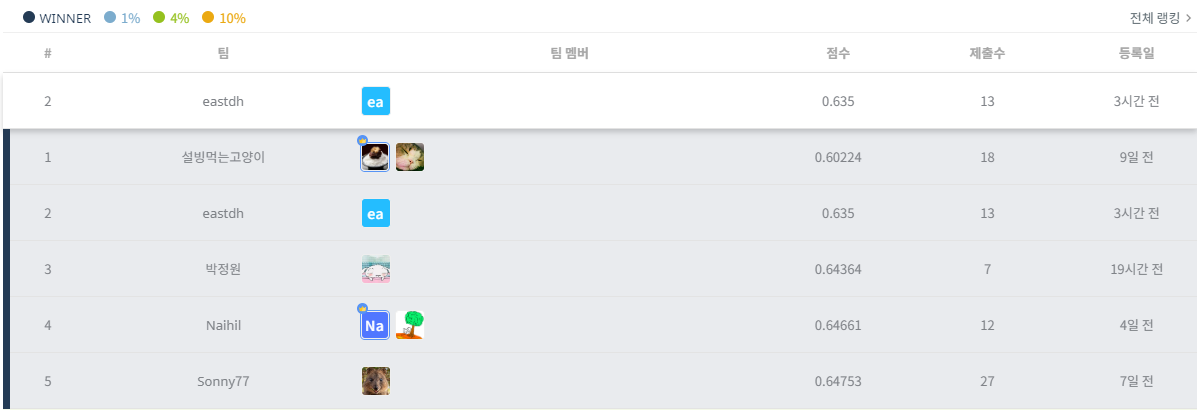

In [31]:
time_end = time.time()
sec = (time_end - time_start)
print("수행 시간:", datetime.timedelta(seconds=sec))
print('종료 시각:', time.strftime('%Y.%m.%d - %H:%M:%S'))

수행 시간: 2:29:53.773033
종료 시각: 2023.05.16 - 03:01:25
